In [37]:
import pandas as pd
from glicko2 import Player

# Load the Excel file
file_path = "Eredivisie 2024-2025 Expected Points.xlsx"
df = pd.read_excel(file_path)

# Clean column names (remove extra spaces)
df.columns = df.columns.str.strip()

# Debugging: Print column names
print("Columns in the DataFrame:", df.columns.tolist())

# Ensure the DataFrame has the necessary columns
if not {'ThuisTeam', 'Uitteam', 'xGThuis', 'xGUit'}.issubset(df.columns):
    raise ValueError("The Excel file must contain 'ThuisTeam', 'Uitteam', 'xGThuis', and 'xGUit' columns.")

# Initialize teams with Glicko-2 ratings
teams = {}

# Function to get or create a team
def get_team(team_id):
    if team_id not in teams:
        teams[team_id] = Player()  # Each team is treated as a Glicko-2 player
    return teams[team_id]

# Process each match
for _, row in df.iterrows():
    home_team = get_team(row['ThuisTeam'])
    away_team = get_team(row['Uitteam'])

    # Determine the result for the home team
    if row['xGThuis'] > row['xGUit']:
        home_result = 1.0  # Home team wins
        away_result = 0.0  # Away team loses
    elif row['xGThuis'] < row['xGUit']:
        home_result = 0.0  # Home team loses
        away_result = 1.0  # Away team wins
    else:
        home_result = 0.5  # Draw
        away_result = 0.5  # Draw

    # Use a weight of 1 for standard matches
    match_weight = 1.0

    # Extract ratings and RDs for update
    home_team_rating = home_team.rating
    home_team_rd = home_team.rd
    away_team_rating = away_team.rating
    away_team_rd = away_team.rd

    # Update ratings for both teams
    home_team.update_player([away_team_rating], [away_team_rd], [home_result])
    away_team.update_player([home_team_rating], [home_team_rd], [away_result])

# Extract updated ratings
ratings = [
    {'Team': team_id, 'Rating': team.rating, 'RD': team.rd, 'Volatility': team.vol}
    for team_id, team in teams.items()
]

# Create a DataFrame with updated ratings
ratings_df = pd.DataFrame(ratings)

# Save the updated ratings to a new Excel file
ratings_df.to_excel("Expected Goal Ranking - 23112024.xlsx", index=False)

print("Updated team ratings saved to 'updated_team_ratings.xlsx'")


Columns in the DataFrame: ['Datum', 'ThuisTeam', 'Thuisgoals', 'Uitgoals', 'Uitteam', 'xGThuis', 'xGUit', 'Kans winst thuisteam', 'Kans gelijkspel', 'Kans winst Uitteam', 'xPointsHome', 'xPointsAway', 'HomePoints', 'AwayPoints', 'HomeWinst', 'HomeGelijk', 'HomeNederlaag', 'AwayWinst', 'AwayGelijk', 'AwayNederlaag']
Updated team ratings saved to 'updated_team_ratings.xlsx'


In [38]:
import pandas as pd
from glicko2 import Player

# Load the match results Excel file
file_path_matches = "Eredivisie 2024-2025 Expected Points.xlsx"
df_matches = pd.read_excel(file_path_matches)

# Load the xG data Excel file
file_path_xg = "/Users/marclambertes/Python/EREXG.xlsx"
df_xg = pd.read_excel(file_path_xg)

# Clean column names (remove extra spaces)
df_matches.columns = df_matches.columns.str.strip()
df_xg.columns = df_xg.columns.str.strip()

# Debugging: Print column names
print("Columns in the Matches DataFrame:", df_matches.columns.tolist())
print("Columns in the xG DataFrame:", df_xg.columns.tolist())

# Ensure the Matches DataFrame has the necessary columns
if not {'ThuisTeam', 'Uitteam', 'xGThuis', 'xGUit'}.issubset(df_matches.columns):
    raise ValueError("The Matches Excel file must contain 'ThuisTeam', 'Uitteam', 'xGThuis', and 'xGUit' columns.")

# Ensure the xG DataFrame has the necessary columns
if not {'TeamId', 'xG'}.issubset(df_xg.columns):
    raise ValueError("The xG Excel file must contain 'TeamId' and 'xG' columns.")

# Compute average xG per team from the xG DataFrame
team_xg = df_xg.groupby('TeamId')['xG'].mean().to_dict()

# Initialize teams with Glicko-2 ratings
teams = {}

# Function to get or create a team
def get_team(team_id):
    if team_id not in teams:
        teams[team_id] = Player()  # Each team is treated as a Glicko-2 player
    return teams[team_id]

# Process each match
for _, row in df_matches.iterrows():
    home_team = get_team(row['ThuisTeam'])
    away_team = get_team(row['Uitteam'])

    # Determine the result for the home team
    if row['xGThuis'] > row['xGUit']:
        home_result = 1.0  # Home team wins
        away_result = 0.0  # Away team loses
    elif row['xGThuis'] < row['xGUit']:
        home_result = 0.0  # Home team loses
        away_result = 1.0  # Away team wins
    else:
        home_result = 0.5  # Draw
        away_result = 0.5  # Draw

    # Incorporate average xG into the match results
    home_xg_avg = team_xg.get(row['ThuisTeam'], 0)  # Default to 0 if no xG data available
    away_xg_avg = team_xg.get(row['Uitteam'], 0)

    # Adjust the home team result based on xG difference
    xg_difference = home_xg_avg - away_xg_avg  # Difference in average xG between teams

    # Adjust the outcome slightly based on xG difference (scale it appropriately)
    adjusted_home_result = home_result + (xg_difference * 0.1)  # 0.1 is the scaling factor for xG
    adjusted_away_result = away_result - (xg_difference * 0.1)  # Negative for away team

    # Ensure the result stays between 0 and 1
    adjusted_home_result = max(0.0, min(1.0, adjusted_home_result))
    adjusted_away_result = max(0.0, min(1.0, adjusted_away_result))

    # Extract ratings and RDs for update
    home_team_rating = home_team.rating
    home_team_rd = home_team.rd
    away_team_rating = away_team.rating
    away_team_rd = away_team.rd

    # Update ratings for both teams using the adjusted results
    home_team.update_player([away_team_rating], [away_team_rd], [adjusted_home_result])
    away_team.update_player([home_team_rating], [home_team_rd], [adjusted_away_result])

# Extract updated ratings
ratings = [
    {
        'Team': team_id,
        'Rating': team.rating,
        'RD': team.rd,
        'Volatility': team.vol,
        'Average_xG': team_xg.get(team_id, 0)  # Include average xG in the output
    }
    for team_id, team in teams.items()
]

# Create a DataFrame with updated ratings
ratings_df = pd.DataFrame(ratings)

# Save the updated ratings to a new Excel file
output_file = "Expected Goal Ranking with xG Integration - 23112024.xlsx"
ratings_df.to_excel(output_file, index=False)

print(f"Updated team ratings with xG saved to '{output_file}'")


Columns in the Matches DataFrame: ['Datum', 'ThuisTeam', 'Thuisgoals', 'Uitgoals', 'Uitteam', 'xGThuis', 'xGUit', 'Kans winst thuisteam', 'Kans gelijkspel', 'Kans winst Uitteam', 'xPointsHome', 'xPointsAway', 'HomePoints', 'AwayPoints', 'HomeWinst', 'HomeGelijk', 'HomeNederlaag', 'AwayWinst', 'AwayGelijk', 'AwayNederlaag']
Columns in the xG DataFrame: ['Unnamed: 0', 'xG', 'Date', 'PlayerId', 'TeamId', 'HomeTeam', 'AwayTeam', 'timeMin', 'timeSec', 'x', 'y', 'angle', 'distance', 'Type_of_play', 'relatedPlayerId', 'GamestateOne', 'GamestateTwo', 'Bodypart', 'isGoal', 'isBigChance', 'isIntentionalAssist', 'isAssistedShot', 'isOwnGoal', 'expandedMinute', 'Goal', 'Time_in_sec', 'Gamestate']
Updated team ratings with xG saved to 'Expected Goal Ranking with xG Integration - 23112024.xlsx'


In [39]:
import pandas as pd
from glicko2 import Player

# Load the match results Excel file
file_path_matches = "Eredivisie 2024-2025 Expected Points.xlsx"
df_matches = pd.read_excel(file_path_matches)

# Load the xG data Excel file
file_path_xg = "/Users/marclambertes/Python/EREXG.xlsx"
df_xg = pd.read_excel(file_path_xg)

# Clean column names (remove extra spaces)
df_matches.columns = df_matches.columns.str.strip()
df_xg.columns = df_xg.columns.str.strip()

# Debugging: Print column names
print("Columns in the Matches DataFrame:", df_matches.columns.tolist())
print("Columns in the xG DataFrame:", df_xg.columns.tolist())

# Ensure the Matches DataFrame has the necessary columns
if not {'ThuisTeam', 'Uitteam', 'xGThuis', 'xGUit'}.issubset(df_matches.columns):
    raise ValueError("The Matches Excel file must contain 'ThuisTeam', 'Uitteam', 'xGThuis', and 'xGUit' columns.")

# Ensure the xG DataFrame has the necessary columns
if not {'TeamId', 'xG', 'Type_of_play'}.issubset(df_xg.columns):
    raise ValueError("The xG Excel file must contain 'TeamId', 'xG', and 'Type_of_play' columns.")

# Filter xG data to include only rows where Type_of_play is one of the desired values
valid_play_types = ["FromCorner", "SetPiece", "ThrowinSetPiece"]
df_xg_filtered = df_xg[df_xg['Type_of_play'].isin(valid_play_types)]

# Compute average xG per team from the filtered xG DataFrame
team_xg = df_xg_filtered.groupby('TeamId')['xG'].mean().to_dict()

# Initialize teams with Glicko-2 ratings
teams = {}

# Function to get or create a team
def get_team(team_id):
    if team_id not in teams:
        teams[team_id] = Player()  # Each team is treated as a Glicko-2 player
    return teams[team_id]

# Process each match
for _, row in df_matches.iterrows():
    home_team = get_team(row['ThuisTeam'])
    away_team = get_team(row['Uitteam'])

    # Determine the result for the home team
    if row['xGThuis'] > row['xGUit']:
        home_result = 1.0  # Home team wins
        away_result = 0.0  # Away team loses
    elif row['xGThuis'] < row['xGUit']:
        home_result = 0.0  # Home team loses
        away_result = 1.0  # Away team wins
    else:
        home_result = 0.5  # Draw
        away_result = 0.5  # Draw

    # Incorporate average xG into the match results
    home_xg_avg = team_xg.get(row['ThuisTeam'], 0)  # Default to 0 if no xG data available
    away_xg_avg = team_xg.get(row['Uitteam'], 0)

    # Adjust the home team result based on xG difference
    xg_difference = home_xg_avg - away_xg_avg  # Difference in average xG between teams

    # Adjust the outcome slightly based on xG difference (scale it appropriately)
    adjusted_home_result = home_result + (xg_difference * 0.1)  # 0.1 is the scaling factor for xG
    adjusted_away_result = away_result - (xg_difference * 0.1)  # Negative for away team

    # Ensure the result stays between 0 and 1
    adjusted_home_result = max(0.0, min(1.0, adjusted_home_result))
    adjusted_away_result = max(0.0, min(1.0, adjusted_away_result))

    # Extract ratings and RDs for update
    home_team_rating = home_team.rating
    home_team_rd = home_team.rd
    away_team_rating = away_team.rating
    away_team_rd = away_team.rd

    # Update ratings for both teams using the adjusted results
    home_team.update_player([away_team_rating], [away_team_rd], [adjusted_home_result])
    away_team.update_player([home_team_rating], [home_team_rd], [adjusted_away_result])

# Extract updated ratings
ratings = [
    {
        'Team': team_id,
        'Rating': team.rating,
        'RD': team.rd,
        'Volatility': team.vol,
        'Average_xG': team_xg.get(team_id, 0)  # Include average xG in the output
    }
    for team_id, team in teams.items()
]

# Create a DataFrame with updated ratings
ratings_df = pd.DataFrame(ratings)

# Save the updated ratings to a new Excel file
output_file = "Expected Goal Ranking with Filtered xG - 23112024.xlsx"
ratings_df.to_excel(output_file, index=False)

print(f"Updated team ratings with filtered xG saved to '{output_file}'")


Columns in the Matches DataFrame: ['Datum', 'ThuisTeam', 'Thuisgoals', 'Uitgoals', 'Uitteam', 'xGThuis', 'xGUit', 'Kans winst thuisteam', 'Kans gelijkspel', 'Kans winst Uitteam', 'xPointsHome', 'xPointsAway', 'HomePoints', 'AwayPoints', 'HomeWinst', 'HomeGelijk', 'HomeNederlaag', 'AwayWinst', 'AwayGelijk', 'AwayNederlaag']
Columns in the xG DataFrame: ['Unnamed: 0', 'xG', 'Date', 'PlayerId', 'TeamId', 'HomeTeam', 'AwayTeam', 'timeMin', 'timeSec', 'x', 'y', 'angle', 'distance', 'Type_of_play', 'relatedPlayerId', 'GamestateOne', 'GamestateTwo', 'Bodypart', 'isGoal', 'isBigChance', 'isIntentionalAssist', 'isAssistedShot', 'isOwnGoal', 'expandedMinute', 'Goal', 'Time_in_sec', 'Gamestate']
Updated team ratings with filtered xG saved to 'Expected Goal Ranking with Filtered xG - 23112024.xlsx'


In [42]:
import pandas as pd
from glicko2 import Player

# Load the match results Excel file
file_path_matches = "Eredivisie 2024-2025 Expected Points.xlsx"
df_matches = pd.read_excel(file_path_matches)

# Load the xG data Excel file
file_path_xg = "/Users/marclambertes/Python/EREXG.xlsx"
df_xg = pd.read_excel(file_path_xg)

# Clean column names (remove extra spaces)
df_matches.columns = df_matches.columns.str.strip()
df_xg.columns = df_xg.columns.str.strip()

# Debugging: Print column names
print("Columns in the Matches DataFrame:", df_matches.columns.tolist())
print("Columns in the xG DataFrame:", df_xg.columns.tolist())

# Ensure the Matches DataFrame has the necessary columns
if not {'ThuisTeam', 'Uitteam', 'xGThuis', 'xGUit', 'Datum'}.issubset(df_matches.columns):
    raise ValueError("The Matches Excel file must contain 'ThuisTeam', 'Uitteam', 'xGThuis', 'xGUit' and 'Datum' columns.")

# Ensure the xG DataFrame has the necessary columns
if not {'TeamId', 'xG', 'Type_of_play'}.issubset(df_xg.columns):
    raise ValueError("The xG Excel file must contain 'TeamId', 'xG', and 'Type_of_play' columns.")

# Filter xG data to include only rows where Type_of_play is one of the desired values
valid_play_types = ["FromCorner", "SetPiece", "ThrowinSetPiece"]
df_xg_filtered = df_xg[df_xg['Type_of_play'].isin(valid_play_types)]

# Compute average xG per team from the filtered xG DataFrame
team_xg = df_xg_filtered.groupby('TeamId')['xG'].mean().to_dict()

# Initialize teams with Glicko-2 ratings
teams = {}

# Function to get or create a team
def get_team(team_id):
    if team_id not in teams:
        teams[team_id] = Player()  # Each team is treated as a Glicko-2 player
    return teams[team_id]

# List to store rankings for each matchday
matchday_rankings = []

# Process each match
for _, row in df_matches.iterrows():
    home_team = get_team(row['ThuisTeam'])
    away_team = get_team(row['Uitteam'])

    # Determine the result for the home team
    if row['xGThuis'] > row['xGUit']:
        home_result = 1.0  # Home team wins
        away_result = 0.0  # Away team loses
    elif row['xGThuis'] < row['xGUit']:
        home_result = 0.0  # Home team loses
        away_result = 1.0  # Away team wins
    else:
        home_result = 0.5  # Draw
        away_result = 0.5  # Draw

    # Incorporate average xG into the match results
    home_xg_avg = team_xg.get(row['ThuisTeam'], 0)  # Default to 0 if no xG data available
    away_xg_avg = team_xg.get(row['Uitteam'], 0)

    # Adjust the home team result based on xG difference
    xg_difference = home_xg_avg - away_xg_avg  # Difference in average xG between teams

    # Adjust the outcome slightly based on xG difference (scale it appropriately)
    adjusted_home_result = home_result + (xg_difference * 0.1)  # 0.1 is the scaling factor for xG
    adjusted_away_result = away_result - (xg_difference * 0.1)  # Negative for away team

    # Ensure the result stays between 0 and 1
    adjusted_home_result = max(0.0, min(1.0, adjusted_home_result))
    adjusted_away_result = max(0.0, min(1.0, adjusted_away_result))

    # Extract ratings and RDs for update
    home_team_rating = home_team.rating
    home_team_rd = home_team.rd
    away_team_rating = away_team.rating
    away_team_rd = away_team.rd

    # Update ratings for both teams using the adjusted results
    home_team.update_player([away_team_rating], [away_team_rd], [adjusted_home_result])
    away_team.update_player([home_team_rating], [home_team_rd], [adjusted_away_result])

    # After updating ratings, rank teams based on their rating
    # Create a DataFrame with updated ratings for this matchday
    matchday_ratings = [
        {'Team': team_id, 'Rating': team.rating, 'RD': team.rd, 'Volatility': team.vol, 'Average_xG': team_xg.get(team_id, 0)}
        for team_id, team in teams.items()
    ]

    matchday_df = pd.DataFrame(matchday_ratings)

    # Rank teams by their rating (higher rating = better rank)
    matchday_df['Rank'] = matchday_df['Rating'].rank(ascending=False, method='min')

    # Add the match date to the DataFrame
    matchday_df['Datum'] = row['Datum']

    # Store the average rating for each team in the matchday data
    matchday_df['Average_Rating'] = matchday_df['Rating']

    # Append the matchday DataFrame to the list of rankings
    matchday_rankings.append(matchday_df)

# Combine all matchday rankings into a single DataFrame
all_matchday_rankings = pd.concat(matchday_rankings)

# Save the updated rankings to a new Excel file
output_file = "Expected Goal Ranking with Filtered xG and Rank - ERE2425.xlsx"
all_matchday_rankings.to_excel(output_file, index=False)

print(f"Updated team rankings with filtered xG, matchday ranks, and average ratings saved to '{output_file}'")


Columns in the Matches DataFrame: ['Datum', 'ThuisTeam', 'Thuisgoals', 'Uitgoals', 'Uitteam', 'xGThuis', 'xGUit', 'Kans winst thuisteam', 'Kans gelijkspel', 'Kans winst Uitteam', 'xPointsHome', 'xPointsAway', 'HomePoints', 'AwayPoints', 'HomeWinst', 'HomeGelijk', 'HomeNederlaag', 'AwayWinst', 'AwayGelijk', 'AwayNederlaag']
Columns in the xG DataFrame: ['Unnamed: 0', 'xG', 'Date', 'PlayerId', 'TeamId', 'HomeTeam', 'AwayTeam', 'timeMin', 'timeSec', 'x', 'y', 'angle', 'distance', 'Type_of_play', 'relatedPlayerId', 'GamestateOne', 'GamestateTwo', 'Bodypart', 'isGoal', 'isBigChance', 'isIntentionalAssist', 'isAssistedShot', 'isOwnGoal', 'expandedMinute', 'Goal', 'Time_in_sec', 'Gamestate']
Updated team rankings with filtered xG, matchday ranks, and average ratings saved to 'Expected Goal Ranking with Filtered xG and Rank - ERE2425.xlsx'


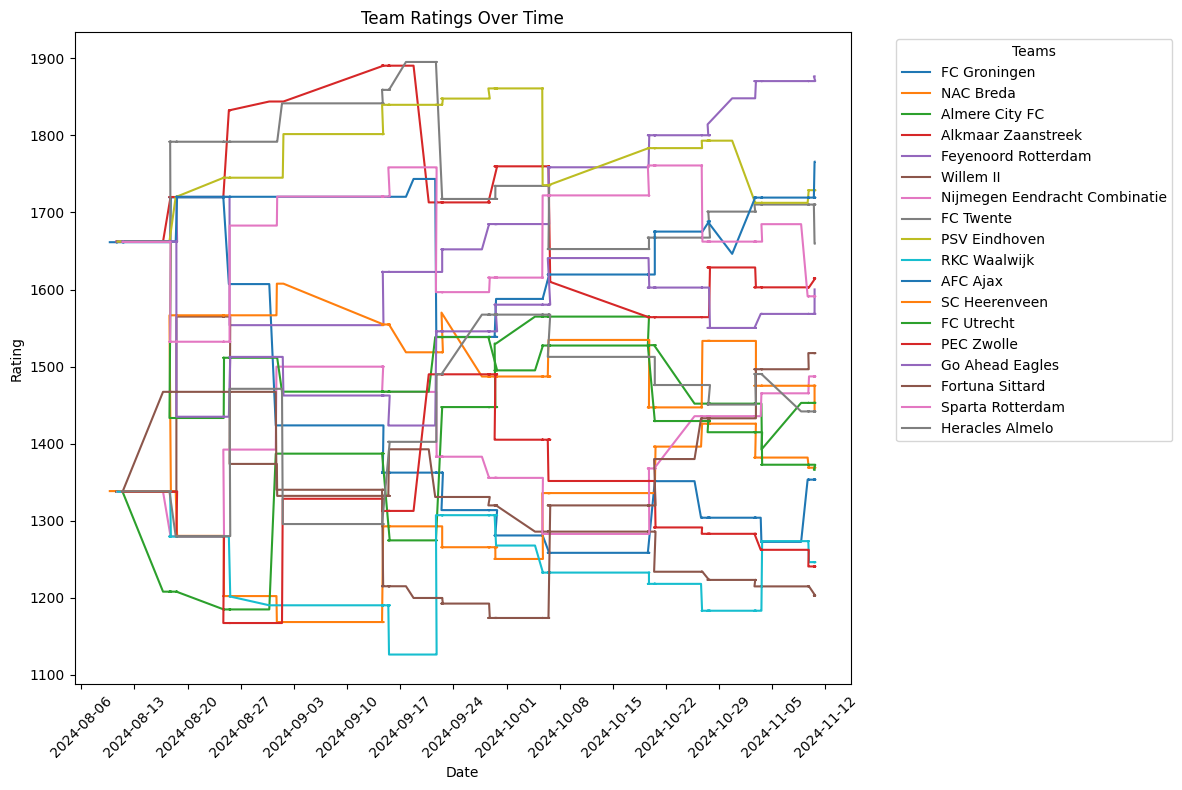

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'Datum' is in datetime format
all_matchday_rankings['Datum'] = pd.to_datetime(all_matchday_rankings['Datum'])

# Get a list of all unique teams
teams = all_matchday_rankings['Team'].unique()

# Create a plot for each team
plt.figure(figsize=(12, 8))

# Loop through each team and plot its rating over time
for team in teams:
    team_data = all_matchday_rankings[all_matchday_rankings['Team'] == team]
    
    # Plot the rating over time (Date on x-axis, Rating on y-axis)
    plt.plot(team_data['Datum'], team_data['Rating'], label=team)

# Add title and labels
plt.title('Team Ratings Over Time')
plt.xlabel('Date')
plt.ylabel('Rating')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Set x-axis ticks to display every week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())  # Weekly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Date format

# Add a legend to show the team names
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Display the plot
plt.show()


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_93637/4269046521.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data['Smoothed_Rating'] = team_data['Rating'].rolling(window=3, min_periods=1).mean()
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_93637/4269046521.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_data['Smoothed_Rating'] = team_data['Rating'].rolling(window=3, min_periods=1).mean()
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_93637/4269046

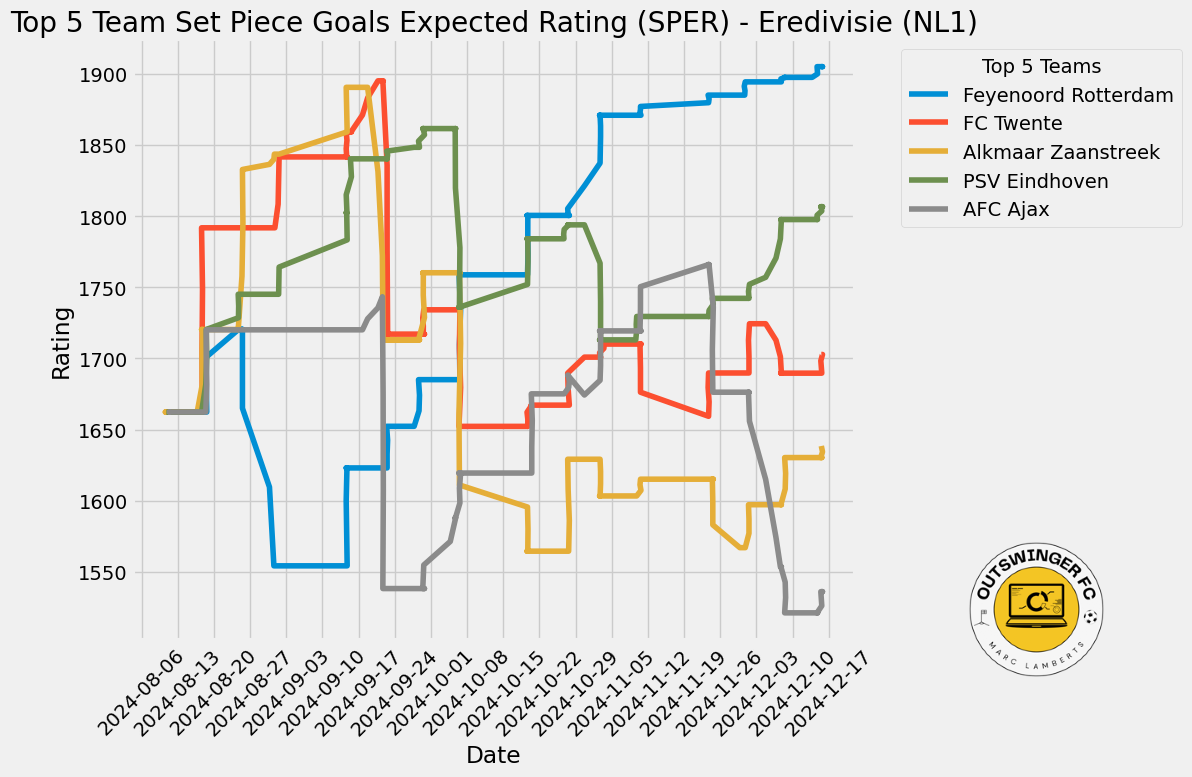

Plot saved as 'top_5_team_sper_eredivisie.png'


In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Ensure 'Datum' is in datetime format
all_matchday_rankings['Datum'] = pd.to_datetime(all_matchday_rankings['Datum'])

# Set the style to FiveThirtyEight
plt.style.use('fivethirtyeight')

# Determine the top 5 teams based on their overall maximum rating
top_5_teams = (
    all_matchday_rankings.groupby('Team')['Rating']
    .max()
    .nlargest(5)
    .index
)

# Create a plot for only the top 5 teams
plt.figure(figsize=(12, 8))

# Plot data for each of the top 5 teams
for team in top_5_teams:
    team_data = all_matchday_rankings[all_matchday_rankings['Team'] == team]
    
    # Smooth the line using a moving average (window size 3 for smoothing)
    team_data['Smoothed_Rating'] = team_data['Rating'].rolling(window=3, min_periods=1).mean()
    
    # Plot the smoothed rating over time
    plt.plot(team_data['Datum'], team_data['Smoothed_Rating'], label=team)

# Add title and labels
plt.title('Top 5 Team Set Piece Goals Expected Rating (SPER) - Eredivisie (NL1)')
plt.xlabel('Date')
plt.ylabel('Rating')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Set x-axis ticks to display every week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add a legend for only the top 5 teams
plt.legend(title='Top 5 Teams', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add a larger logo positioned more to the right
logo_path = "/Users/marclambertes/Python/Outswinger FC (3).png"  # Replace with the path to your logo
logo_image = plt.imread(logo_path)  # Read the logo image
imagebox = OffsetImage(logo_image, zoom=0.6)  # Increased zoom for larger size
ab = AnnotationBbox(
    imagebox, 
    (1.25, 0.05),  # Adjusted position (further right and slightly lower)
    frameon=False,
    xycoords='axes fraction'
)
plt.gca().add_artist(ab)

# Adjust layout to make room for the legend and logo
plt.tight_layout()

# Save the plot to a PNG file
output_path = "top_5_team_sper_eredivisie.png"  # Specify the output file name
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save with high resolution and trimmed edges

# Display the plot
plt.show()

print(f"Plot saved as '{output_path}'")


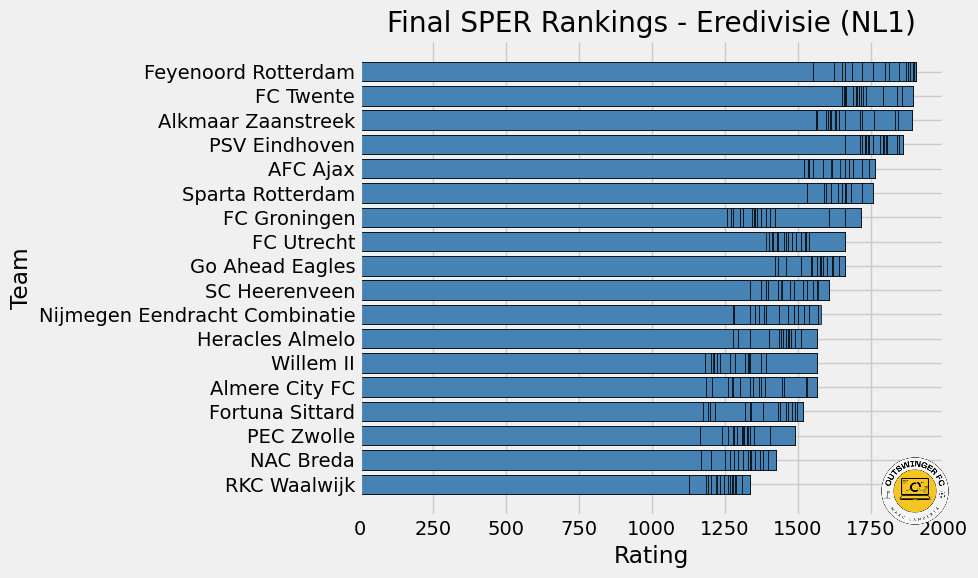

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Assume 'all_matchday_rankings' DataFrame is pre-loaded

# Ensure 'Datum' is in datetime format
all_matchday_rankings['Datum'] = pd.to_datetime(all_matchday_rankings['Datum'])

# Determine the final rankings based on the latest date for each team
final_rankings = (
    all_matchday_rankings.loc[all_matchday_rankings.groupby('Team')['Datum'].idxmax()]
    .sort_values(by='Rating', ascending=False)
)

# Plotting the bar graph
plt.figure(figsize=(10, 6))

# Plot bar graph for the final rankings
plt.barh(
    final_rankings['Team'], 
    final_rankings['Rating'], 
    color='steelblue', 
    edgecolor='black'
)

# Add title and labels
plt.title('Final SPER Rankings - Eredivisie (NL1)')
plt.xlabel('Rating')
plt.ylabel('Team')

# Invert the y-axis to have the highest rating on top
plt.gca().invert_yaxis()

# Add a logo to the bar graph
logo_path = "/Users/marclambertes/Python/Outswinger FC (3).png"  # Replace with your logo path
logo_image = plt.imread(logo_path)  # Read the logo image
imagebox = OffsetImage(logo_image, zoom=0.3)  # Adjust zoom level for logo size
ab = AnnotationBbox(
    imagebox, 
    (0.95, 0.05),  # Adjust logo position (right corner)
    frameon=False, 
    xycoords='axes fraction'
)
plt.gca().add_artist(ab)

# Adjust layout
plt.tight_layout()

# Save the bar graph to a PNG file
output_path = "final_sper_rankings_eredivisie.png"  # Specify the output file name
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save with high resolution 
